In [1]:
!pip install emoji==1.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171033 sha256=f9dc0d92e9e4bb9df05122ac431737e17ecda99124d762fb73dde6231d8a0e25
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re, string
import emoji

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from keras.optimizers.legacy import SGD
from keras.optimizers import RMSprop
from keras.callbacks import LearningRateScheduler
from keras.callbacks import History
from keras import losses

In [3]:
df = pd.read_csv('Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [5]:
df = df[['text','airline_sentiment']]
df.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [6]:
# Clean hastags '#' Symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet))
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet))
    return new_tweet2

#Remove punctuations, links
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower()
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    text = re.sub(r'[^\x00-\x7f]',r'', text)
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

# Clean emoji from text
def strip_emoji(text):
    return re.sub(emoji.get_emoji_regexp(), r"", text)

# Remove multiple spaces
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

texts_new = []
for t in df.text:
    texts_new.append(remove_mult_spaces(clean_hashtags(strip_all_entities(strip_emoji(t)))))

df['cleaned_text'] = texts_new

# rearrange the column order
df = df.reindex(columns=['text','cleaned_text', 'airline_sentiment'])
df.head()


<ipython-input-6-47fe248dd722>:19: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  return re.sub(emoji.get_emoji_regexp(), r"", text)


,text,cleaned_text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,what said,neutral
1,@VirginAmerica plus you've added commercials t...,plus youve added commercials to the experience...,positive
2,@VirginAmerica I didn't today... Must mean I n...,i didnt today must mean i need to take another...,neutral
3,@VirginAmerica it's really aggressive to blast...,its really aggressive to blast obnoxious enter...,negative
4,@VirginAmerica and it's a really big bad thing...,and its a really big bad thing about it,negative


In [7]:
tokenizer = Tokenizer(num_words=512, lower=True, split=' ')
tokenizer.fit_on_texts(df['cleaned_text'])

X = tokenizer.texts_to_sequences(df['cleaned_text'])

token_lens = []

for token in X:
    token_lens.append(len(token))

print(np.max(token_lens))

MAX_LEN=32
X = pad_sequences(X, padding='post', maxlen=MAX_LEN)

29


In [8]:
#Label encoding
df['airline_sentiment'] = df['airline_sentiment'].map({'negative': 0, 'neutral': 1, 'positive':2})
df.head()

,text,cleaned_text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,what said,1
1,@VirginAmerica plus you've added commercials t...,plus youve added commercials to the experience...,2
2,@VirginAmerica I didn't today... Must mean I n...,i didnt today must mean i need to take another...,1
3,@VirginAmerica it's really aggressive to blast...,its really aggressive to blast obnoxious enter...,0
4,@VirginAmerica and it's a really big bad thing...,and its a really big bad thing about it,0


In [9]:
y = pd.get_dummies(df['airline_sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)


Train Set -> (8784, 32) (8784, 3)
Validation Set -> (2928, 32) (2928, 3)
Test Set -> (2928, 32) (2928, 3)


<ipython-input-10-08ea542bc29b>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='airline_sentiment', data=df, palette='viridis')


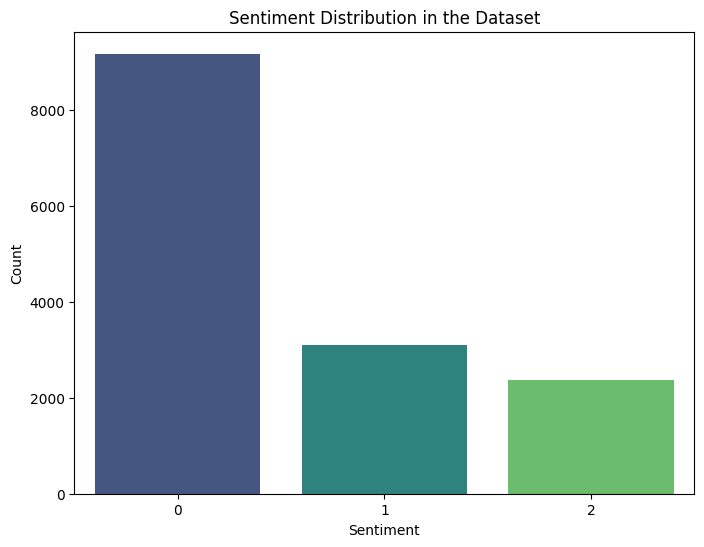

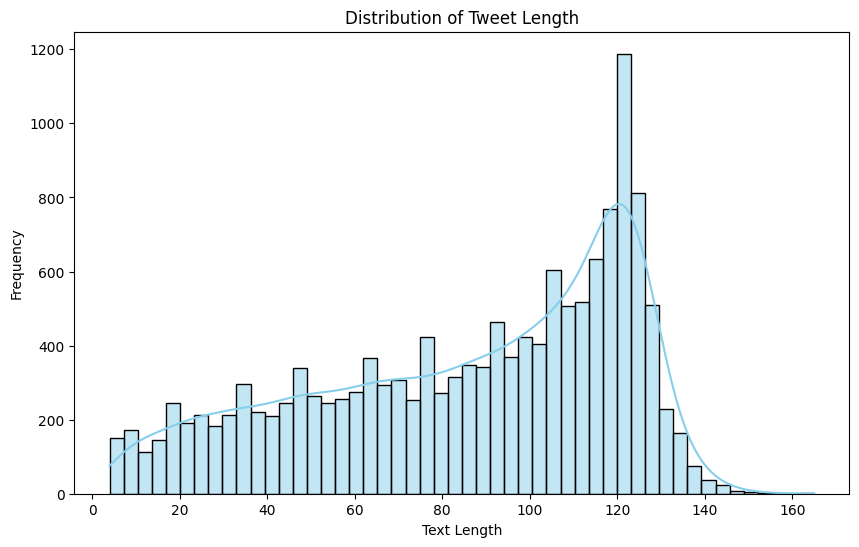

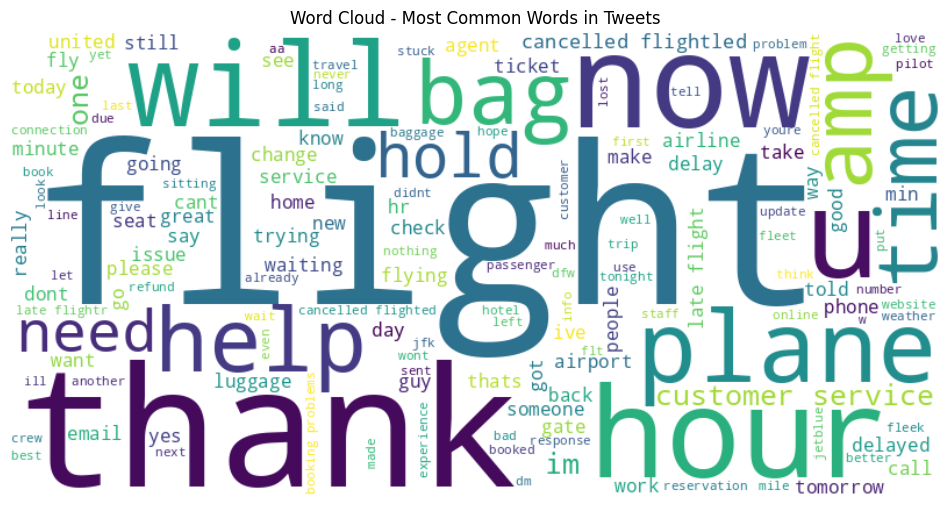

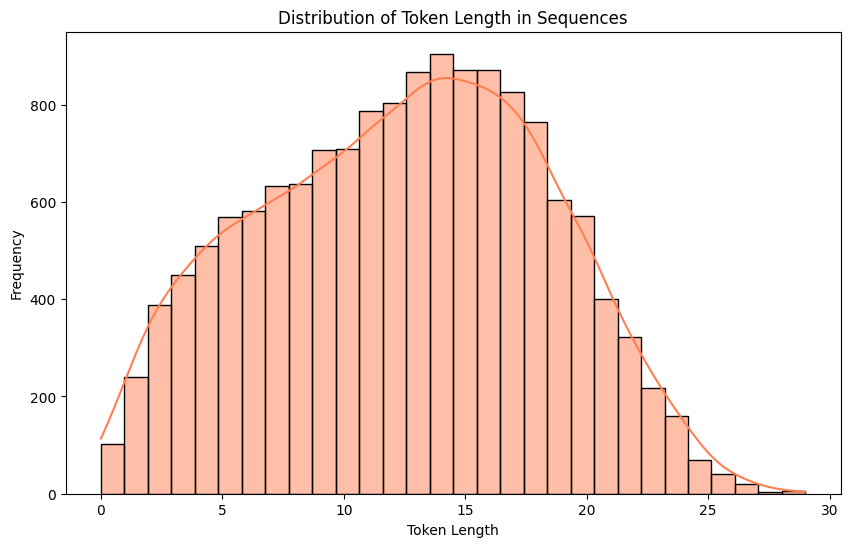

<ipython-input-10-08ea542bc29b>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='airline_sentiment', data=df, palette='coolwarm')


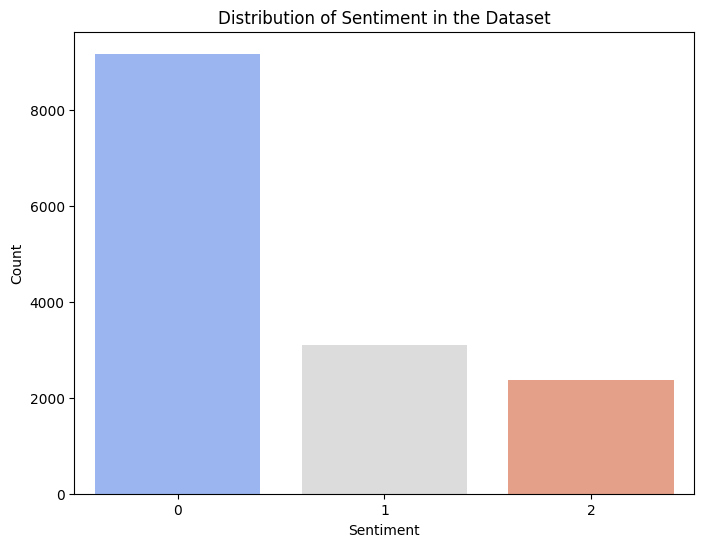

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization 1: Sentiment Distribution
sentiment_counts = df['airline_sentiment'].value_counts()
plt.figure(figsize=(8, 6))
sns.countplot(x='airline_sentiment', data=df, palette='viridis')
plt.title('Sentiment Distribution in the Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Visualization 2: Distribution of Tweet Length
df['text_length'] = df['cleaned_text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50, color='skyblue', kde=True)
plt.title('Distribution of Tweet Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# Visualization 3: Most Common Words
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, max_words=150, background_color='white').generate(' '.join(df['cleaned_text']))
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Most Common Words in Tweets')
plt.show()

# Visualization 4: Distribution of Token Length
plt.figure(figsize=(10, 6))
sns.histplot(token_lens, bins=30, color='coral', kde=True)
plt.title('Distribution of Token Length in Sequences')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.show()

# Visualization 5: Distribution of Sentiment
plt.figure(figsize=(8, 6))
sns.countplot(x='airline_sentiment', data=df, palette='coolwarm')
plt.title('Distribution of Sentiment in the Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


In [11]:
!pip install torch

## 1 - Base LSTM model

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score

# Set random seed for reproducibility
torch.manual_seed(42)

# Define LSTM model architecture with three LSTM layers
class LSTMModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim1, batch_first=True, bidirectional=False)
        self.lstm2 = nn.LSTM(hidden_dim1, hidden_dim2, batch_first=True, bidirectional=False)
        self.lstm3 = nn.LSTM(hidden_dim2, hidden_dim3, batch_first=True, bidirectional=False)
        self.dropout = nn.Dropout(0.3)  # Added dropout layer
        self.fc = nn.Linear(hidden_dim3, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out1, _ = self.lstm1(embedded)
        lstm_out2, _ = self.lstm2(lstm_out1)
        lstm_out3, _ = self.lstm3(lstm_out2)
        lstm_out3 = self.dropout(lstm_out3)  # Applied dropout
        output = self.fc(lstm_out3[:, -1, :])
        return output


In [23]:
# Hyperparameters
EMBEDDING_DIM = 192
HIDDEN_DIM1 = 128
HIDDEN_DIM2 = 24
HIDDEN_DIM3 = 24
OUTPUT_DIM = 3
BATCH_SIZE = 16
NUM_EPOCHS = 10

# Instantiate the model
input_dim = 512
lstm_model = LSTMModel(input_dim, EMBEDDING_DIM, HIDDEN_DIM1, HIDDEN_DIM2, HIDDEN_DIM3, OUTPUT_DIM)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

from torch.nn.parallel import DataParallel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = lstm_model.to(device)

# Wrap the model with DataParallel if multiple GPUs are available
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    lstm_model = DataParallel(lstm_model)

# Convert data to PyTorch tensors
X_train_tensor = torch.LongTensor(X_train)
y_train_tensor = torch.LongTensor(y_train.values.argmax(axis=1))
X_val_tensor = torch.LongTensor(X_val)
y_val_tensor = torch.LongTensor(y_val.values.argmax(axis=1))
X_test_tensor = torch.LongTensor(X_test).to(device)
y_test_tensor = torch.LongTensor(y_test.values.argmax(axis=1)).to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

# Arrays to store training and validation metrics for visualization
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop with metrics printing and logging
for epoch in range(NUM_EPOCHS):
    lstm_model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = lstm_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # Validation
    lstm_model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = lstm_model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            total_val_loss += val_loss.item()

            _, predicted_val = val_outputs.max(1)
            total_val += val_labels.size(0)
            correct_val += predicted_val.eq(val_labels).sum().item()

    val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val

    # Print and store metrics
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

# Evaluate on the test set
lstm_model.eval()
test_outputs = lstm_model(X_test_tensor)
test_loss = criterion(test_outputs, y_test_tensor)
test_preds = torch.argmax(test_outputs, dim=1)
test_accuracy = accuracy_score(y_test_tensor.cpu().numpy(), test_preds.cpu().numpy())
print(f"Test Set Loss: {test_loss.item()}, Test Set Accuracy: {test_accuracy}")




Epoch 1/10, Train Loss: 0.8972, Train Acc: 0.6338, Val Loss: 0.7758, Val Acc: 0.6831
Epoch 2/10, Train Loss: 0.7151, Train Acc: 0.7014, Val Loss: 0.6487, Val Acc: 0.7452
Epoch 3/10, Train Loss: 0.6147, Train Acc: 0.7600, Val Loss: 0.6345, Val Acc: 0.7507
Epoch 4/10, Train Loss: 0.5475, Train Acc: 0.7979, Val Loss: 0.5993, Val Acc: 0.7688
Epoch 5/10, Train Loss: 0.4872, Train Acc: 0.8251, Val Loss: 0.6328, Val Acc: 0.7606
Epoch 6/10, Train Loss: 0.4335, Train Acc: 0.8521, Val Loss: 0.6362, Val Acc: 0.7630
Epoch 7/10, Train Loss: 0.3828, Train Acc: 0.8730, Val Loss: 0.6351, Val Acc: 0.7510
Epoch 8/10, Train Loss: 0.3207, Train Acc: 0.8988, Val Loss: 0.6827, Val Acc: 0.7575
Epoch 9/10, Train Loss: 0.2790, Train Acc: 0.9134, Val Loss: 0.7418, Val Acc: 0.7466
Epoch 10/10, Train Loss: 0.2427, Train Acc: 0.9260, Val Loss: 0.7150, Val Acc: 0.7520
Test Set Loss: 0.7293010950088501, Test Set Accuracy: 0.7503415300546448


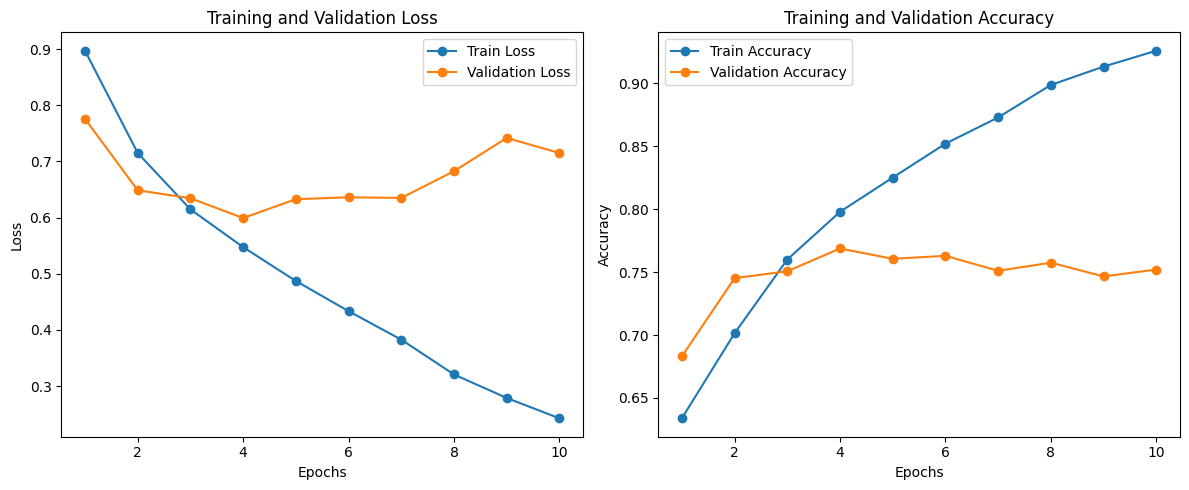

In [24]:
# Visualization of Training and Validation Metrics
import matplotlib.pyplot as plt

epochs_range = range(1, NUM_EPOCHS + 1)

# Plotting Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss', marker='o')
plt.plot(epochs_range, val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
# Save the trained model state
torch.save(lstm_model.state_dict(), "pytorch_lstm_model.pth")

## 2 - Stacked Lstm

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score

# Set random seed for reproducibility
torch.manual_seed(42)

# Define Improved LSTM model architecture with at least three LSTM layers
class ImprovedLSTM(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, num_layers=3, bidirectional=True):
        super(ImprovedLSTM, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm_layers = nn.ModuleList()

        for layer in range(num_layers):
            input_size = embedding_dim if layer == 0 else hidden_dim * 2 if bidirectional else hidden_dim
            self.lstm_layers.append(nn.LSTM(input_size, hidden_dim, batch_first=True, bidirectional=bidirectional))

        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)

        # Iterate through LSTM layers
        for lstm_layer in self.lstm_layers:
            lstm_out, _ = lstm_layer(embedded)
            embedded = lstm_out

        output = self.fc(lstm_out[:, -1, :])
        return output


In [27]:
# Hyperparameters
EMBEDDING_DIM = 256
HIDDEN_DIM1 = 128
HIDDEN_DIM2 = 24
OUTPUT_DIM = 3
BATCH_SIZE = 64
NUM_EPOCHS = 10

# Instantiate the model
input_dim = 512 
lstm_model = ImprovedLSTM(input_dim, EMBEDDING_DIM, HIDDEN_DIM1, OUTPUT_DIM, bidirectional=True)

from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3)

torch.nn.utils.clip_grad_norm_(lstm_model.parameters(), max_norm=1)

from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3)


from torch.nn.parallel import DataParallel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = lstm_model.to(device)

# Wrap the model with DataParallel if multiple GPUs are available
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    lstm_model = DataParallel(lstm_model)

# Convert data to PyTorch tensors
X_train_tensor = torch.LongTensor(X_train)
y_train_tensor = torch.LongTensor(y_train.values.argmax(axis=1))
X_val_tensor = torch.LongTensor(X_val)
y_val_tensor = torch.LongTensor(y_val.values.argmax(axis=1))
X_test_tensor = torch.LongTensor(X_test).to(device)
y_test_tensor = torch.LongTensor(y_test.values.argmax(axis=1)).to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Arrays to store training and validation metrics for visualization
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop with metrics printing and logging
for epoch in range(NUM_EPOCHS):
    lstm_model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = lstm_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # Validation
    lstm_model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = lstm_model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            total_val_loss += val_loss.item()

            _, predicted_val = val_outputs.max(1)
            total_val += val_labels.size(0)
            correct_val += predicted_val.eq(val_labels).sum().item()

    val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val

    # Print and store metrics
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    scheduler.step(val_loss)

# Evaluate on the test set
lstm_model.eval()
test_outputs = lstm_model(X_test_tensor)
test_loss = criterion(test_outputs, y_test_tensor)
test_preds = torch.argmax(test_outputs, dim=1)
test_accuracy = accuracy_score(y_test_tensor.cpu().numpy(), test_preds.cpu().numpy())
print(f"Test Set Loss: {test_loss.item()}, Test Set Accuracy: {test_accuracy}")




Epoch 1/10, Train Loss: 0.9242, Train Acc: 0.6232, Val Loss: 0.9086, Val Acc: 0.6322
Epoch 2/10, Train Loss: 0.8459, Train Acc: 0.6421, Val Loss: 0.7165, Val Acc: 0.6752
Epoch 3/10, Train Loss: 0.6565, Train Acc: 0.7236, Val Loss: 0.6684, Val Acc: 0.7421
Epoch 4/10, Train Loss: 0.5865, Train Acc: 0.7658, Val Loss: 0.6143, Val Acc: 0.7616
Epoch 5/10, Train Loss: 0.5291, Train Acc: 0.7950, Val Loss: 0.6130, Val Acc: 0.7568
Epoch 6/10, Train Loss: 0.4891, Train Acc: 0.8138, Val Loss: 0.6625, Val Acc: 0.7439
Epoch 7/10, Train Loss: 0.4444, Train Acc: 0.8305, Val Loss: 0.7033, Val Acc: 0.7585
Epoch 8/10, Train Loss: 0.3858, Train Acc: 0.8545, Val Loss: 0.6528, Val Acc: 0.7606
Epoch 9/10, Train Loss: 0.3252, Train Acc: 0.8847, Val Loss: 0.6548, Val Acc: 0.7640
Epoch 10/10, Train Loss: 0.2684, Train Acc: 0.9145, Val Loss: 0.7294, Val Acc: 0.7681
Test Set Loss: 0.734263002872467, Test Set Accuracy: 0.7609289617486339


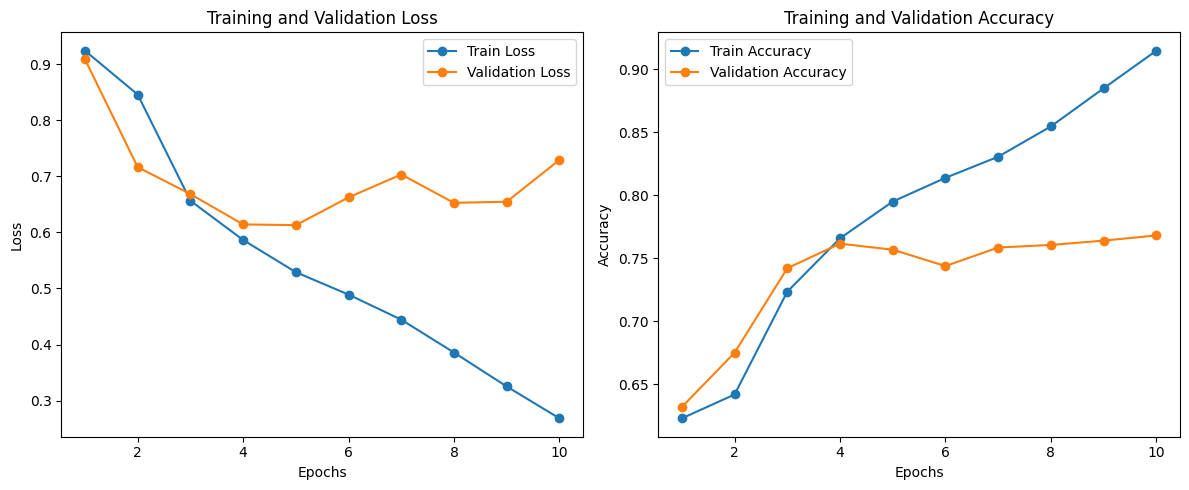

In [28]:
# Visualization of Training and Validation Metrics
import matplotlib.pyplot as plt

epochs_range = range(1, NUM_EPOCHS + 1)

# Plotting Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss', marker='o')
plt.plot(epochs_range, val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [29]:
# Save the trained model state
torch.save(lstm_model.state_dict(), "improved_lstm_model.pth")
